# Finetune Tutorial

This tutorial demonstrates how to finetune the scLinguist model on a custom dataset and then use it to predict protein expression from RNA data. (Basically, this task is similar to fewshot task.)

Import necessary packages and define paths for checkpoints and save directory.

In [20]:
from pathlib import Path
from torch.utils.data import DataLoader
import sys
sys.path.append('../../')
from scLinguist.data_loaders.data_loader import scMultiDataset
from scLinguist.model.configuration_hyena import HyenaConfig
from scLinguist.model.model import scTrans
import importlib, sys
sys.modules['model'] = importlib.import_module('scLinguist.model')

ENCODER_CKPT = Path("../../pretrained_model/encoder.ckpt")
DECODER_CKPT = Path("../../pretrained_model/decoder.ckpt")
FINETUNE_CKPT = Path("../../pretrained_model/finetune.ckpt")
SAVE_DIR = Path("../../docs/tutorials/finetune_output")
SAVE_DIR.mkdir(exist_ok=True)

Configure dataloaders for fewshot and test datasets.

First, inspect the data structure of the datasets to ensure they are compatible with the model.

In [21]:
import scanpy as sc
rna_train = sc.read_h5ad('../../data/train_sample_rna.h5ad')
rna_train

AnnData object with n_obs × n_vars = 16994 × 19202
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'cell_type'

In [22]:
rna_train.X.todense()

matrix([[ 0.,  0.,  0., ..., 15.,  1., 27.],
        [ 0.,  0.,  0., ...,  0.,  0.,  2.],
        [ 0.,  0.,  0., ...,  2.,  0.,  7.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  6.],
        [ 0.,  0.,  0., ...,  0.,  0.,  4.],
        [ 0.,  0.,  0., ...,  1.,  0.,  6.]], dtype=float32)

In [23]:
rna_train.var_names

Index(['ENSG00000186092', 'ENSG00000284733', 'ENSG00000284662',
       'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187961',
       'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290',
       'ENSG00000187608',
       ...
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198938', 'ENSG00000198840', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000198727'],
      dtype='object', length=19202)

In [24]:
import scanpy as sc
rna_test = sc.read_h5ad('../../data/test_sample_rna.h5ad')
rna_test

AnnData object with n_obs × n_vars = 10546 × 19202
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'cell_type'

In [25]:
rna_test.X.todense()

matrix([[ 0.,  0.,  0., ...,  5.,  0.,  3.],
        [ 0.,  0.,  0., ...,  0.,  0.,  7.],
        [ 0.,  0.,  0., ...,  1.,  0.,  6.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  2.],
        [ 0.,  0.,  0., ...,  2.,  0.,  2.],
        [ 0.,  0.,  0., ...,  4.,  0., 12.]], dtype=float32)

In [26]:
rna_test.var_names

Index(['ENSG00000186092', 'ENSG00000284733', 'ENSG00000284662',
       'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187961',
       'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290',
       'ENSG00000187608',
       ...
       'ENSG00000198712', 'ENSG00000228253', 'ENSG00000198899',
       'ENSG00000198938', 'ENSG00000198840', 'ENSG00000212907',
       'ENSG00000198886', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000198727'],
      dtype='object', length=19202)

In [27]:
import scanpy as sc
adt_train = sc.read_h5ad('../../data/train_sample_adt.h5ad')
adt_train

AnnData object with n_obs × n_vars = 16994 × 6427
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'cell_type'

In [28]:
import numpy as np
mask = ~np.isnan(adt_train.X[0].toarray())
adt_train[:, mask].X.todense()

matrix([[1.100e+02, 1.400e+01, 4.900e+01, ..., 1.100e+01, 2.120e+02,
         2.800e+01],
        [1.200e+02, 1.000e+00, 5.890e+02, ..., 2.000e+00, 3.600e+01,
         2.400e+01],
        [6.450e+02, 5.000e+00, 1.256e+03, ..., 1.000e+00, 7.200e+01,
         1.320e+02],
        ...,
        [2.330e+02, 2.700e+01, 8.420e+02, ..., 3.000e+00, 7.700e+01,
         4.600e+01],
        [3.120e+02, 1.500e+01, 1.079e+03, ..., 4.000e+00, 4.800e+01,
         8.000e+01],
        [1.960e+02, 2.000e+00, 1.910e+02, ..., 0.000e+00, 3.400e+01,
         1.900e+01]])

In [29]:
adt_train.var_names

Index(['SP110', 'GTPBA', 'SNX2', 'FRG1', 'TT21A', 'RHG18', 'AR', 'DOCK1',
       'RAB1A', 'MUC1.HMFG2',
       ...
       'CYTSA', 'LFNG', 'PFKFB4', 'LIPB1', 'ZN225', 'TRI69', 'CCL14', 'ZN541',
       'TAP1', 'SCG3'],
      dtype='object', length=6427)

In [30]:
import scanpy as sc
adt_test = sc.read_h5ad('../../data/test_sample_adt.h5ad')
adt_test

AnnData object with n_obs × n_vars = 10546 × 6427
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'cell_type'

Then, create the dataloaders for both finetune and test datasets. The `scMultiDataset` class is used to load the RNA and protein data from the specified paths.

In [31]:
BATCH_SIZE = 32
train_ds = scMultiDataset(
    data_dir_1="../../data/train_sample_rna.h5ad",
    data_dir_2="../../data/train_sample_adt.h5ad",
)
valid_ds = scMultiDataset(
    data_dir_1="../../data/valid_sample_rna.h5ad",
    data_dir_2="../../data/valid_sample_adt.h5ad",
)
test_ds = scMultiDataset(
    data_dir_1="../../data/test_sample_rna.h5ad",
    data_dir_2="../../data/test_sample_adt.h5ad",
)

train_dataloader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
)
valid_dataloader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    pin_memory=True,
)


Last, configure the model with the appropriate encoder and decoder checkpoints, and set the mode to "RNA-protein". The `HyenaConfig` class is used to define the model configuration parameters such as `d_model`, `emb_dim`, `max_seq_len`, `vocab_len`, and `n_layer`.

In [32]:
enc_cfg = HyenaConfig(
    d_model        = 128,
    emb_dim        = 5,
    max_seq_len    = 19202,
    vocab_len      = 19202,
    n_layer        = 1,
    output_hidden_states=False,
)
dec_cfg = HyenaConfig(
    d_model        = 128,
    emb_dim        = 5,
    max_seq_len    = 6427,
    vocab_len      = 6427,
    n_layer        = 1,
    output_hidden_states=False,
)
model = scTrans(
        enc_cfg,
        dec_cfg,
        encoder_ckpt_path=ENCODER_CKPT,
        decoder_ckpt_path=DECODER_CKPT,
        lr=0.001,
        mask_prob=0.6
    )
model = scTrans.load_from_checkpoint(checkpoint_path=FINETUNE_CKPT)
# model.encoder_ckpt_path = ENCODER_CKPT
# model.decoder_ckpt_path = DECODER_CKPT
model.mode = "RNA-protein"

Start training the model using PyTorch Lightning. The `ModelCheckpoint` callback is used to save the best model based on validation loss, and the `EarlyStopping` callback is used to stop training if the validation loss does not improve for a specified number of epochs.

In [33]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

ckpt_cb = ModelCheckpoint(
    dirpath      = SAVE_DIR/"ckpt",
    monitor      = "valid_loss_epoch",
    mode         = "min",
    save_top_k   = 10,
    filename     = "best-{epoch}-{valid_loss_epoch:.4f}",
    save_last = True
)

trainer = pl.Trainer(
    accelerator       = "gpu",
    devices           = [1],
    max_epochs        = 6,
    log_every_n_steps = 50,
    callbacks         = [ckpt_cb],
)

trainer.fit(model, train_dataloader, valid_dataloader)
best_ckpt = ckpt_cb.best_model_path


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | scHeyna_enc      | 313 K 
1 | decoder    | scHeyna_dec      | 249 K 
2 | translator | MLPTranslator    | 284 M 
3 | cos_gene   | CosineSimilarity | 0     
4 | cos_cell   | CosineSimilarity | 0     
------------------------------------------------
285 M     Trainable params
0         Non-trainable params
285 M     Total params
1,141.275 Total estimated model params size (MB)
/home/miaozy/miniconda3/envs/scgpt/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory ../../docs/tutorials/finetune_output/ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Inference with the trained model on the test dataset. Use RNA data to predict proteins in ../../docs/tutorials/protein_names.txt, here we use all proteins in the test data.

In [34]:
test_adata = sc.read_h5ad("../../data/test_sample_rna.h5ad")

sc.pp.normalize_total(test_adata, target_sum=10000)
sc.pp.log1p(test_adata)

rna_tensor = torch.tensor(test_adata.X.todense(), dtype=torch.float32).cuda()
model.eval().cuda()

BATCH_SIZE = 16
pred_chunks = []
with torch.no_grad():
    X = rna_tensor
    for i in range(0, X.shape[0], BATCH_SIZE):
        xb = X[i:i+BATCH_SIZE].to("cuda", non_blocking=True)
        _, _, pred_b = model(xb)
        pred_chunks.append(pred_b.detach().cpu())
        del xb, pred_b
protein_pred = torch.cat(pred_chunks, dim=0)

# predict given proteins
target_proteins = adt_test[:, mask].var_names.tolist()
prot_map = pd.read_csv("../../docs/tutorials/protein_index_map.csv")
name_to_idx = dict(zip(prot_map["name"], prot_map["index"]))
idx = [name_to_idx[p] for p in target_proteins if p in name_to_idx]

pred_df = pd.DataFrame(
    protein_pred[:, idx].cpu().numpy(),
    columns = target_proteins,
    index   = test_adata.obs_names,
)
pred_df.to_csv(SAVE_DIR/"predicted_protein_expression.csv")

Finally, we evaluate scLinguist with Pearson and MMD, then visualize the protein expression pattern to demonstrate scLinguist's ability to recover celltype-specific patterns.

[Metrics] {'pearson': 0.9226795434951782, 'mmd_raw': 0.072367824614048}


/home/miaozy/miniconda3/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/miaozy/miniconda3/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


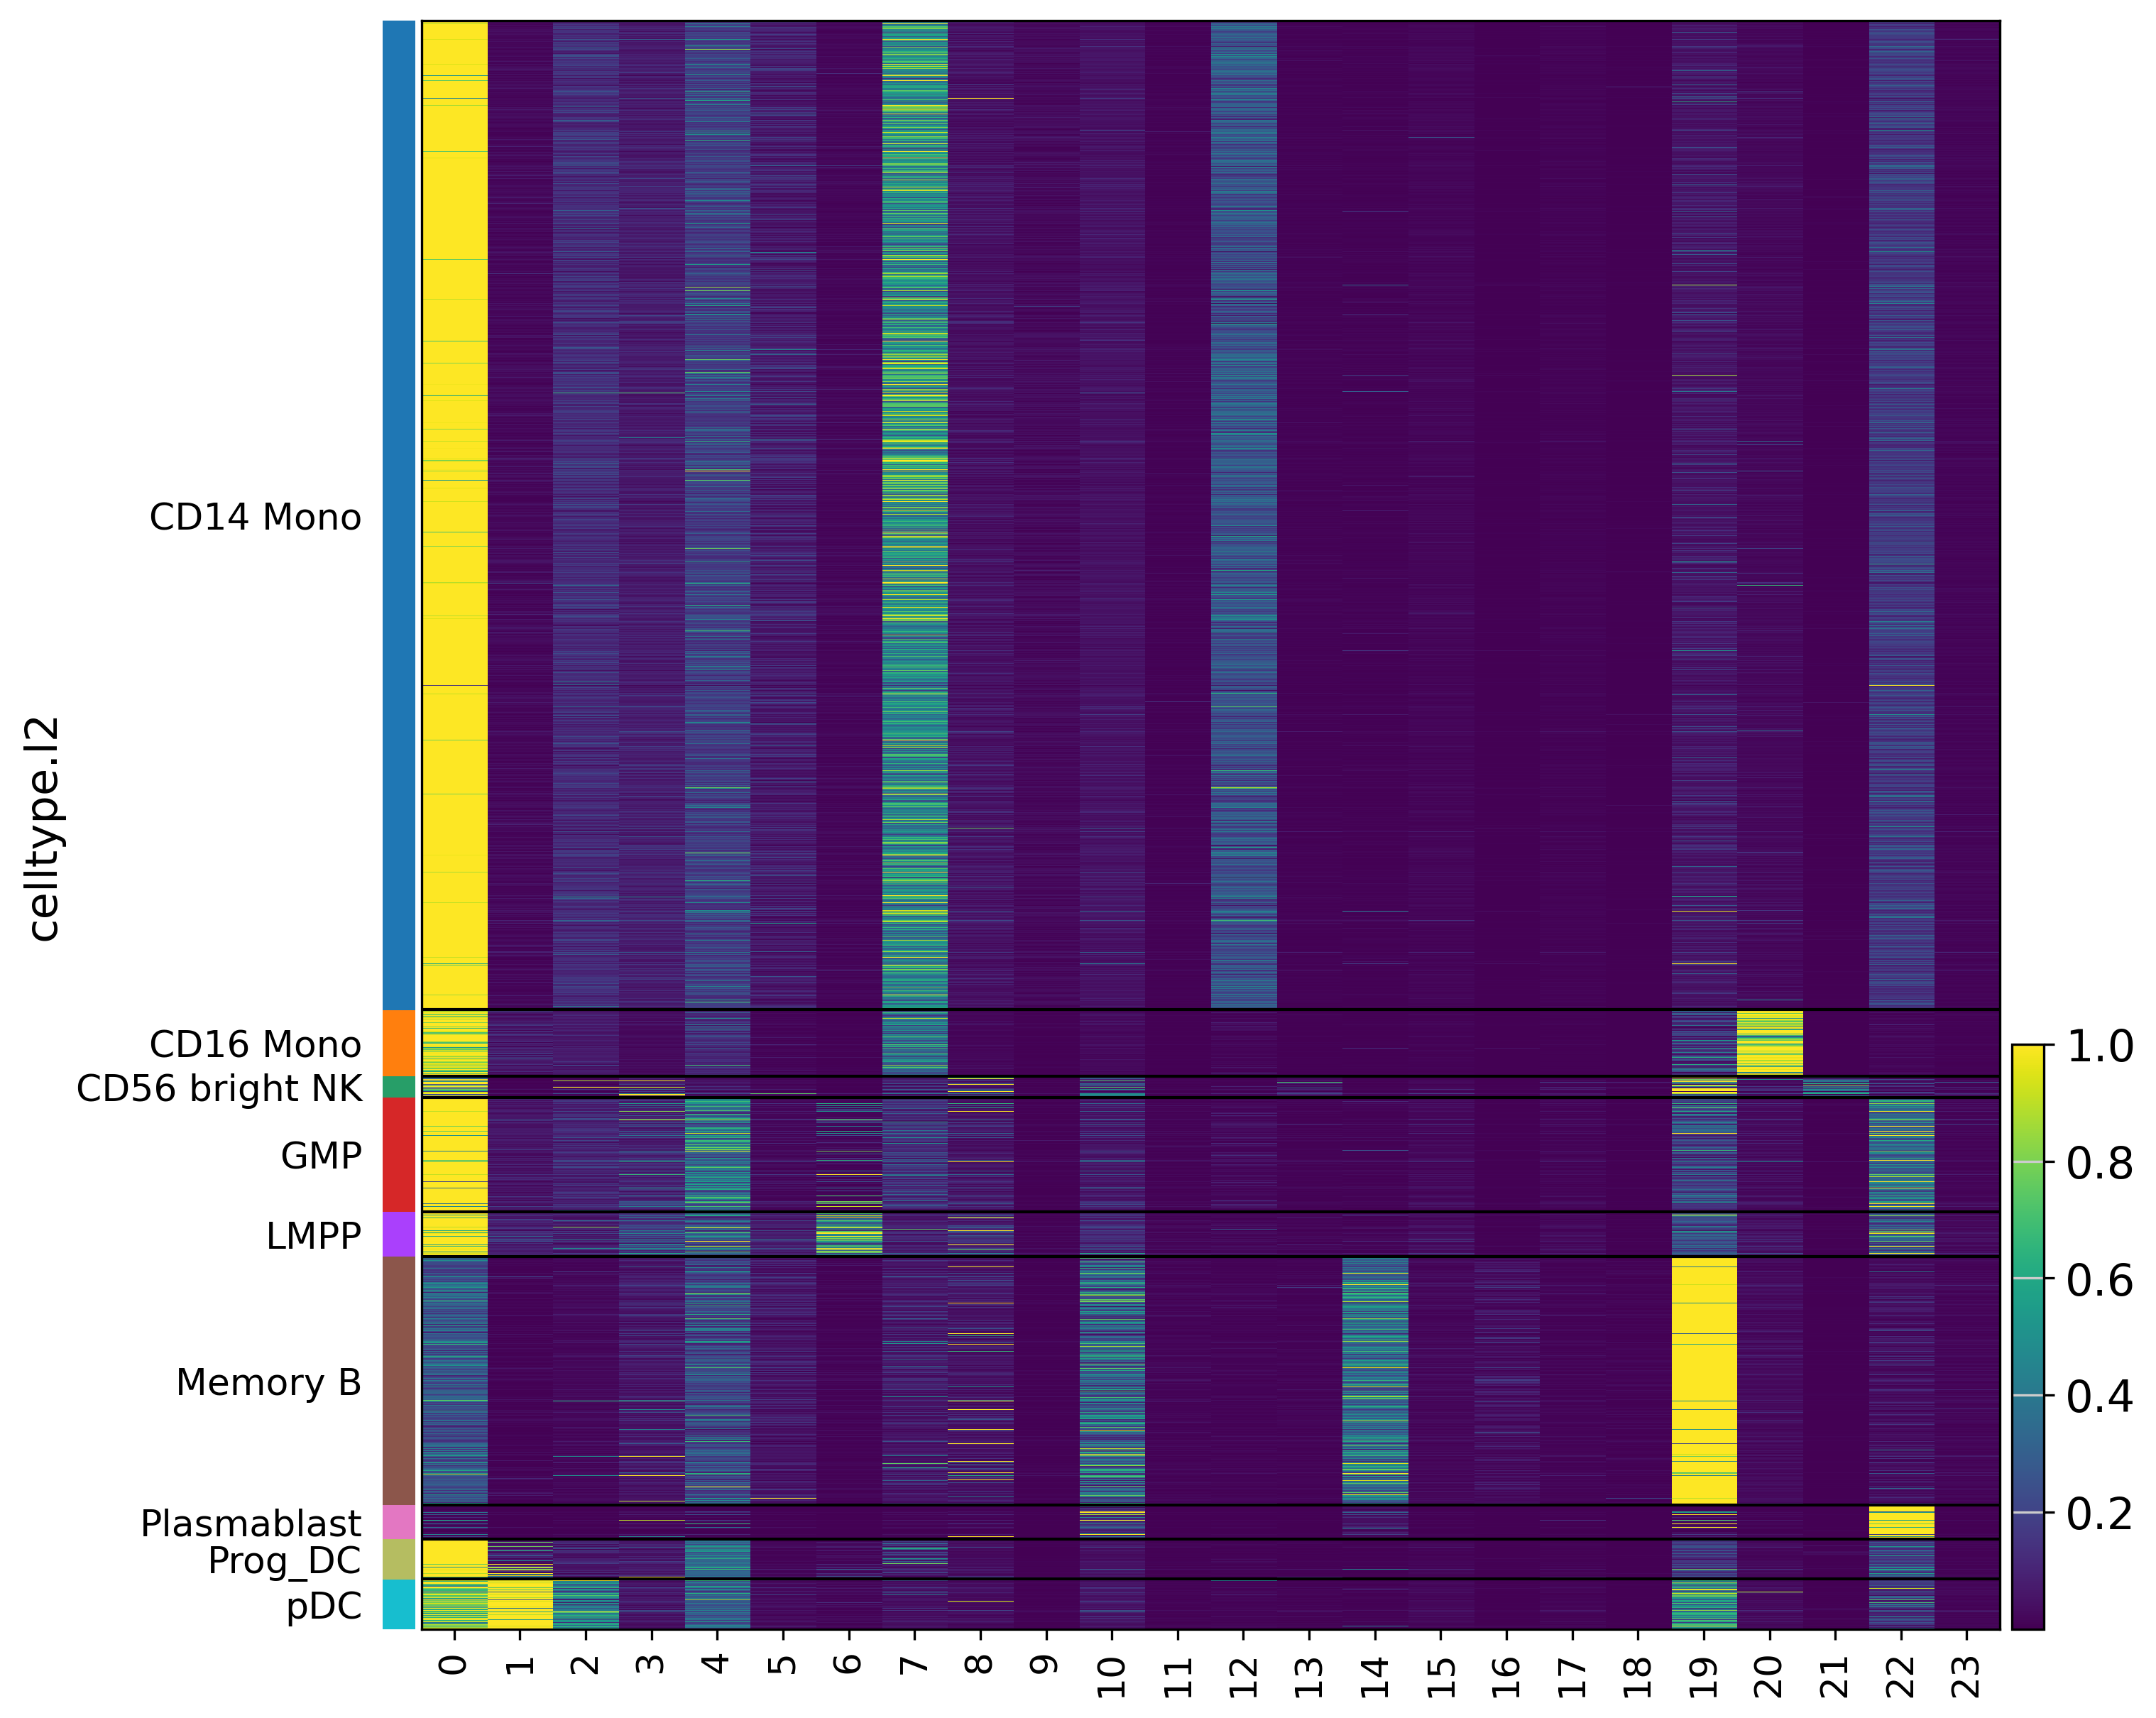

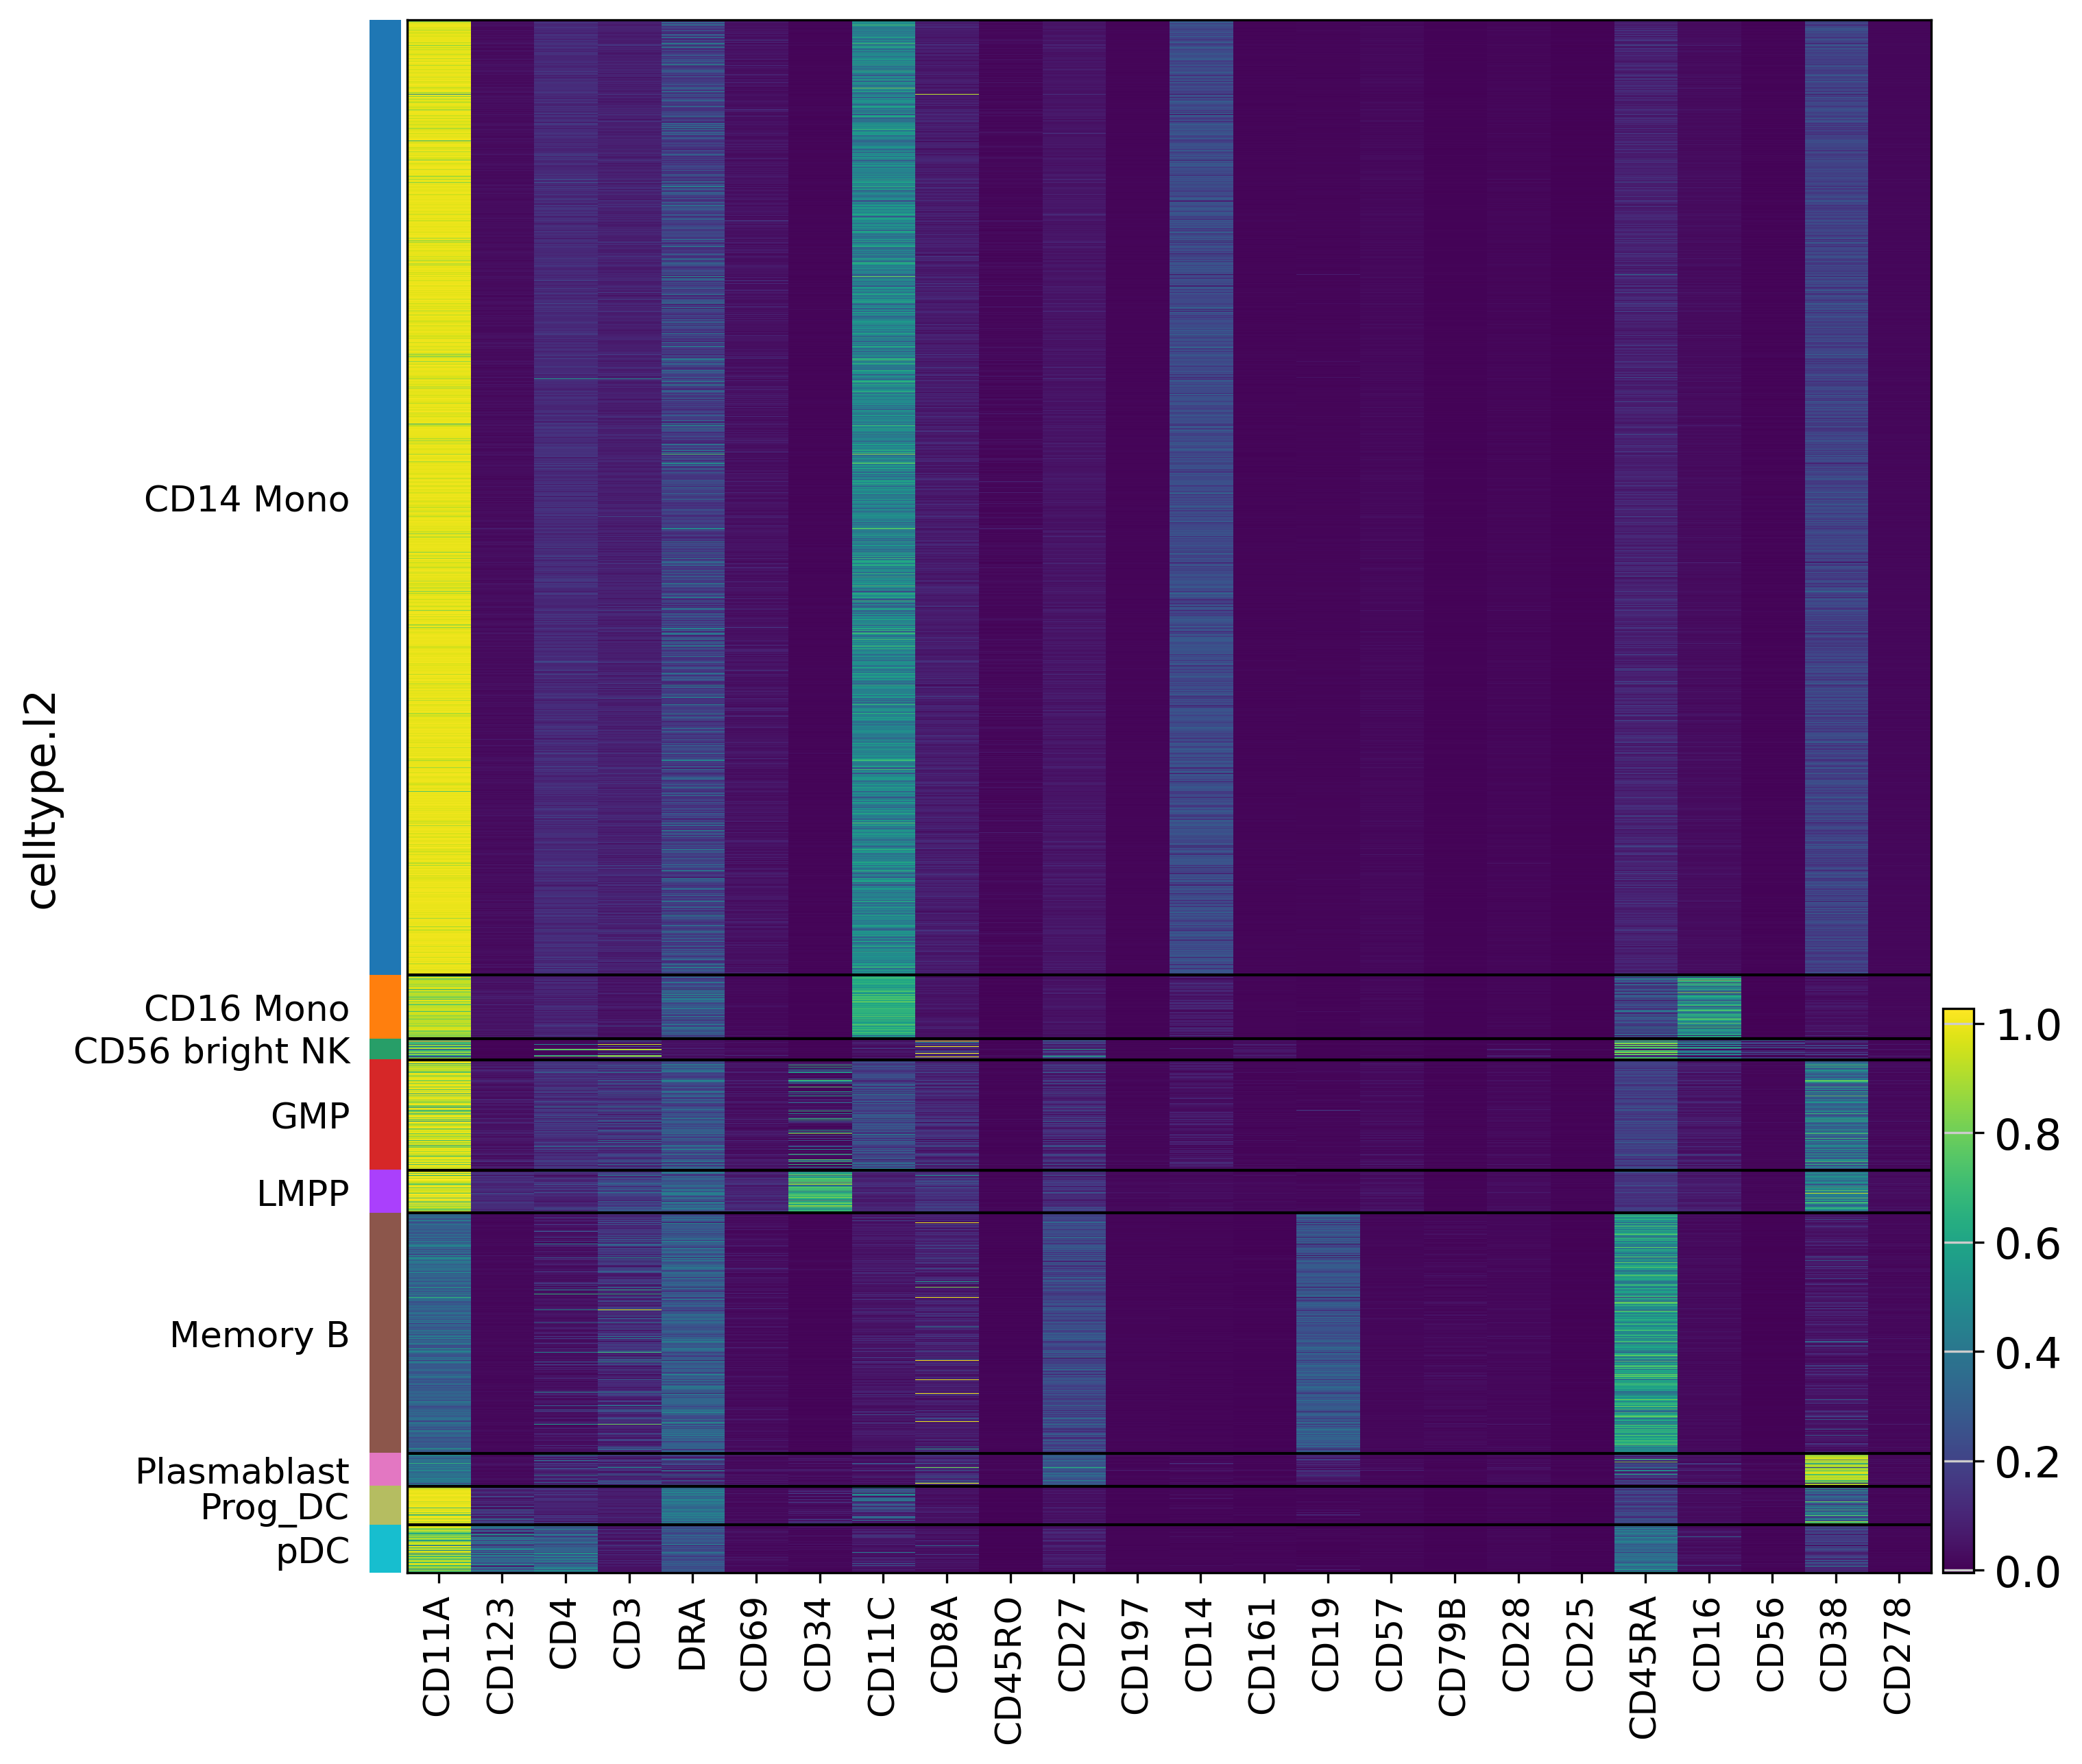

In [36]:
adt_real = sc.read_h5ad("../../data/test_sample_adt.h5ad")
adt_sub = adt_real[:, target_proteins]
Y_np = adt_sub.X.toarray() if hasattr(adt_sub.X, "toarray") else np.asarray(adt_sub.X)

# protein preprocessing
from scLinguist.data_loaders.data_loader import max_min_normalization_with_nan
Y_np = max_min_normalization_with_nan(Y_np)

Y_true = torch.from_numpy(Y_np).to(torch.float32)
Y_pred = torch.from_numpy(pred_df.values).to(torch.float32)

def PearsonCorr1d(y_true, y_pred):
    assert len(y_true.shape) == 1
    y_true_c = y_true - torch.mean(y_true)
    y_pred_c = y_pred - torch.mean(y_pred)
    pearson = torch.mean(torch.sum(y_true_c * y_pred_c) / (torch.sqrt(torch.sum(y_true_c * y_true_c)) + 1e-8)
                        / (torch.sqrt(torch.sum(y_pred_c * y_pred_c)) + 1e-8))
    return pearson

overall_pearson = float(PearsonCorr1d(Y_true.flatten(), Y_pred.flatten()).detach().cpu().item())

def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = source.size(0) + target.size(0)
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(n_samples, n_samples, -1)
    total1 = total.unsqueeze(1).expand(n_samples, n_samples, -1)
    L2_dist = ((total0 - total1) ** 2).sum(2)

    if fix_sigma is not None:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_dist) / (n_samples * (n_samples - 1))
    bandwidth = bandwidth.detach()
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernels = sum(torch.exp(-L2_dist / bw) for bw in bandwidth_list)
    return kernels

def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Maximum Mean Discrepancy (MMD) between source and target using RBF kernel.
    Args:
        source (Tensor): (n_samples, features)
        target (Tensor): (n_samples, features)
    """
    batch_size = source.size(0)
    kernels = gaussian_kernel(source, target,
                            kernel_mul=kernel_mul,
                            kernel_num=kernel_num,
                            fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY - YX)
    return loss

mmd_raw = float(mmd_rbf(Y_true, Y_pred).detach().cpu().item())
summary = {
    "pearson": overall_pearson,
    "mmd_raw": mmd_raw
}
print("[Metrics]", summary)

from scLinguist.data_loaders.data_loader import max_min_normalization_with_nan
import anndata as ad
from scipy.sparse import csr_matrix
true_df = pd.DataFrame(adt_sub.X.toarray())
_true = true_df
_pred = pred_df

adata_true  = ad.AnnData(csr_matrix(_true.values),
                        obs=pd.DataFrame(index=_true.index),
                        var=pd.DataFrame(index=_true.columns))
adata_recon = ad.AnnData(csr_matrix(_pred.values),
                        obs=pd.DataFrame(index=_pred.index),
                        var=pd.DataFrame(index=_pred.columns))
adata_true.obs = adt_sub.obs.copy()
adata_recon.obs = adt_sub.obs.copy()
_group_col = "celltype.l2"

adata_true.X  = max_min_normalization_with_nan(adata_true.X.toarray())

adata_true.var_names_make_unique()
adata_recon.var_names_make_unique()
adata_true.raw  = adata_true.copy()
adata_recon.raw = adata_recon.copy()

sc.set_figure_params(scanpy=True, fontsize=15, figsize=(20, 20), dpi=150)
if _group_col in adata_true.obs.columns:
    sc.pl.heatmap(adata_true,  adata_true.var_names,  groupby=_group_col,
                cmap='viridis', figsize=(10, 10), show=True)
    sc.pl.heatmap(adata_recon, adata_recon.var_names, groupby=_group_col,
                cmap='viridis', figsize=(10, 10), show=True)
else:
    sc.pl.heatmap(adata_true,  adata_true.var_names,
                cmap='viridis', figsize=(10, 10), show=True)
    sc.pl.heatmap(adata_recon, adata_recon.var_names,
                cmap='viridis', figsize=(10, 10), show=True)